In [11]:
!pip install openfermion --upgrade
!pip install h5py --upgrade
!pip install openfermionpyscf qulacs scipy
!pip install py3Dmol

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /opt/conda/lib/python3.7/site-packages/h5py-3.1.0.dist-info/*
    /opt/conda/lib/python3.7/site-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /opt/conda/lib/python3.7/site-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /opt/conda/lib/python3.7/site-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /opt/conda/lib/python3.7/site-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /opt/conda/lib/python3.7/site-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /opt/conda/lib/python3.7/site-packages/h5py/*
Proceed (Y/n)?   Successfully uninstalled h5py-3.1.0
  Using cached h5py-3.1.0-cp37-cp37m-manylinux1_x86_64.whl (4.0 MB)

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notic

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, symmetry_conserving_bravyi_kitaev
from openfermion.ops import FermionOperator
from pyscf import gto, scf, tools
from qchem_util import get_molecular_hamiltonian_from_fcidump
from qulacs.observable import create_observable_from_openfermion_text
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import X, RY, CNOT, merge, RY

# 量子変分固有値法（VQE)を用いた基底状態計算

さて、ここまでで、量子コンピュータ上に電子の波動関数やハミルトニアンを載せる方法を学んだ。
分子のエネルギー計算を量子コンピュータで実行するには、あとは、
量子コンピュータを使って、以下の固有値問題をどう解くかがわかれば良い。
$$H\Psi = E\Psi$$


この方法もハミルトニアンの変換法と同様に複数存在する。
将来的にどの計算法がデファクトスタンダードとなるかは、まだ未知数であるが、
代表的なものは位相推定法（Phase Estimation Algorithm, PEA)と変分量子固有値法(Variational Quantum Eigensolver, VQE)の２つである。
PEAは厳密解を多項式時間で解くことができるアルゴリズムであり、
古典アルゴリズムに対する優位性が保証された方法となっている。
しかし、PEAの量子回路は非常に深くなるため、水素分子のようなミニマルな系以外では、NISQ上で動作することは望めない。

これに対して、VQEは量子回路$U(\theta)$を使って、求めたい量子状態の近似波動関数$\Psi_T(\theta)$を表現し、量子回路のパラメータ$\theta$は、$E_T(\theta) = \langle \Phi_T(\theta) | H | \Phi_T(\theta) \rangle$が最小化されるように古典コンピュータ上で決定する。VQEで用いる$U(\theta)は$PEAに比べて浅い回路で良く、NISQでも（ある程度）動作する。

「03_量子演算を変分的に分解する」や「08_簡単な量子回路学習を実行してみる 」では、コスト関数の最小化をおこなったが、VQEもコスト関数にエネルギーを使って同様のことをおこなっている。


## 復習: 水素分子のハミルトニアンをqubit表現で用意

さて、これまでの復習になるが、水素分子のハミルトニアンを用意してみる。


In [3]:
# 水素分子、H-H距離は0.74Å と設定。STO-3GというGaussian型の原子基底関数を使用。
mol_h2 = gto.M(atom = 'H 0 0 0; H 0 0 0.74', basis = 'sto-3g')
# この水素分子の基底状態を平均場近似（Hartree-Fock theory)で計算してみる。
mean_field_wavefunction = scf.RHF(mol_h2)
mean_field_wavefunction.verbose = 0
hf_energy = mean_field_wavefunction.kernel()
# 第二量子化された電子のハミルトニアンを構築し、fcidump 形式で保存
tools.fcidump.from_scf(mean_field_wavefunction, 'fcidump.rhf') 
# OpenFermionに第二量子化されたハミルトニアンをロード
fermion_hamiltonian = get_fermion_operator(get_molecular_hamiltonian_from_fcidump('fcidump.rhf'))
# Jordan-Wigner変換をおｋなう
jw_qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
print (jw_qubit_hamiltonian)

Parsing fcidump.rhf
(-0.09706626816763086+0j) [] +
(-0.04530261550379928+0j) [X0 X1 Y2 Y3] +
(0.04530261550379928+0j) [X0 Y1 Y2 X3] +
(0.04530261550379928+0j) [Y0 X1 X2 Y3] +
(-0.04530261550379928+0j) [Y0 Y1 X2 X3] +
(0.1714128264477691+0j) [Z0] +
(0.16868898170361213+0j) [Z0 Z1] +
(0.1206252348339042+0j) [Z0 Z2] +
(0.16592785033770346+0j) [Z0 Z3] +
(0.1714128264477692+0j) [Z1] +
(0.16592785033770346+0j) [Z1 Z2] +
(0.1206252348339042+0j) [Z1 Z3] +
(-0.22343153690813464+0j) [Z2] +
(0.17441287612261575+0j) [Z2 Z3] +
(-0.22343153690813466+0j) [Z3]


## 量子回路上でのHartree-Fock状態の用意

さて、VQEの量子回路$U(\theta)$は、何かしらの初期波動関数$|\Psi_0\rangle$に作用して、近似波動関数を生成する。
$$|\Psi(\theta)_T\rangle = U(\theta) |\Psi_0\rangle$$
初期波動関数をどうするかは難しい問題であるが、Hartree-Fock波動関数は重ね合わせがない状態のため、簡単に用意でき、かつ既にみたように化学の問題においては99%程度の精度を持っている、という点で優れている。

では、qulacsを使って、Hartree-Fock状態を用意しよう。


In [4]:
n_qubit = 4 
hf_state = QuantumState(n_qubit) # 4qubitの量子状態を用意。この時点では|0000> 
hf_state.set_computational_basis(int('0b0011',2)) # |0011>を用意

STO-3G基底関数を使った時の水素分子のHartree-Fockエネルギー -1.1167593073964248 が正しく得られているか確認してみよう。
まず、OpenFermion形式で得られたハミルトニアンをqulacsで使える形式に変換する。

In [5]:
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_qubit_hamiltonian))

hf_stateを使って、qulacs_hamiltonianの期待値を計算すれば、Hartree-Fockエネルギーが計算できる。

In [6]:
qulacs_hamiltonian.get_expectation_value(hf_state)

-1.1167593073964257

この値は、PySCFで計算した、Hartree-Fock Energy -1.1167593073964248 と一致していることが見て取れる。

# 波動関数を表す量子回路$U(\theta)$の用意

波動関数のモデルのことを物理では、ansatzと呼ぶ。
このansatzが、VQEの場合、量子回路$U(\theta)$となっている。
どういった 分子の波動関数に対してどういった$U(\theta)$がいいかは今も研究がおこなわれている最中であり、決定打となるようなものはまだ存在しない（と少なくとも思われている）。

ここでは、Gard et al. による粒子数を保存する回路を用いることにしよう。
（https://www.nature.com/articles/s41534-019-0240-1)



In [7]:
def create_A_gate(theta, target_two_qubits):
  first = target_two_qubits[0]
  second = target_two_qubits[1]
  CNOT02 = CNOT(first, second)
  CRY0 = RY(first, theta+np.pi/2)
  CRY0_minus = RY(first, -(theta+np.pi/2))
  CNOT20 = CNOT(second, first)
  return merge(merge(merge(merge(CNOT02, CRY0), CNOT20), CRY0_minus), CNOT02)

In [8]:
create_A_gate(0.0, [0, 2])

 *** gate info *** 
 * gate name : DenseMatrix
 * target    : 
 0 : commute       
 2 : commute       
 * control   : 
 * Pauli     : no
 * Clifford  : no
 * Gaussian  : no
 * Parametric: no
 * Diagonal  : no
 * Matrix
          (1,0)           (0,0)           (0,0)           (0,0)
          (0,0)           (1,0) (2.22045e-16,0)           (0,0)
          (0,0) (2.22045e-16,0)          (-1,0)           (0,0)
          (0,0)           (0,0)           (0,0)           (1,0)

この粒子数保存回路は、2つの量子ビットに作用し、１電子の移動（励起）を表現できる。
この回路を組み合わせて作ったアンザッツ(ansatz)を使ってコスト関数（エネルギー）を計算するルーチンを以下のように用意する。

In [9]:
n_repeat = 2 #量子回路の深さ
def cost(parameters):
    #初期波動関数の用意
    n_qubit = 4 
    state = QuantumState(n_qubit) # 4qubitの量子状態を用意。この時点では|0000> 
    state.set_computational_basis(int('0b0011',2)) # |0011>を用意
    #ansatz(量子回路を用意)
    num_paras = len(parameters)
    ansatz = QuantumCircuit(n_qubit)
    for i in range(n_repeat):
        idx = 2*i 
        ansatz.add_gate(create_A_gate(parameters[idx], [0, 2]))
        ansatz.add_gate(create_A_gate(parameters[idx+1], [1, 3]))
        ansatz.add_gate(create_A_gate(parameters[idx], [1, 2]))
    #近似波動関数の生成
    ansatz.update_quantum_state(state)
    return qulacs_hamiltonian.get_expectation_value(state) #エネルギーを返す。

このコスト関数を最適化すれば、VQE計算を実行したことになる。
では、実行してみよう。

Convderged VQE Energy (in hartree) -1.1371944668006475
c.f., Full CI Energy (in hartree)  -1.1372838344885023


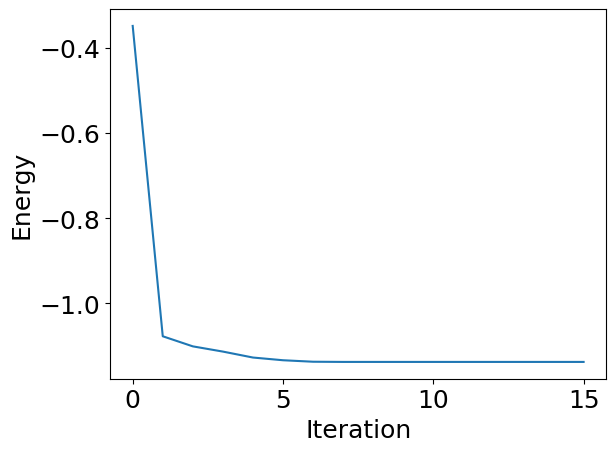

In [10]:
import scipy.optimize

cost_history = []

#パラメータの初期値
init_theta_list = [np.random.random() for i in range(n_repeat*2)]
#init_theta_list = [0.1 for i in range(n_repeat*2)]
cost_history.append(cost(init_theta_list))

method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

#print (cost_history)
print ("Convderged VQE Energy (in hartree)", cost_history[-1])
print ("c.f., Full CI Energy (in hartree)  -1.1372838344885023")
plt.rcParams["font.size"] = 18
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

VQE Energyが 0.001 hartree以下の誤差で、Full CIのエネルギーを再現していることが見て取れる。n_repeatの数を増やして、もっと深い量子回路にすれば、Full CIと厳密に一致する解を得ることができる。逆に、n_repeatの数を減らすと(i.e., 1)、精度が低下することが確認できるので、実行してみよう。


## 活性空間の概念とより大きな系の計算

量子コンピュータを使った量子化学計算では、考慮する軌道の数だけ量子ビットが必要です。
そのため複雑で大きな系の場合、その系の波動関数を全て量子コンピュータ上で表現することは、沢山の量子ビットがあっても現実的ではありません。
化学的に重要な自由度のみを真面目に取り扱い、残りの自由度は比較的安価な方法（例えば平均場近似や摂動論）で記述するという戦略が量子化学では昔から取られてきました。
量子化学においては、前者のことを活性空間と呼びます。
量子コンピュータが直接扱うを自由度をこうして限定することで、リアリスティックな系のシミュレーションが可能になります。
ここでは、活性空間近似を使ったより実際的な系の量子化学計算として、

酢酸が酸化チタン表面に吸着するエネルギーを計算してみます。

まず、この系を可視化してみましょう。

In [19]:
import py3Dmol

def visualize_mole(xyzfile):
    view = py3Dmol.view(width=400, height=400)
    with open(xyzfile) as f:
        xyz_str = f.read()
    view.addModel(xyz_str, "xyz")
    view.setStyle({'stick': {}, 'sphere': {'scale': .30}}, viewer=(0,0))
    view.setBackgroundColor('#ebf4fb', viewer=(0,0))
    view.show()

In [20]:
visualize_mole("qchem/AA_TiO2.xyz")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

吸着エネルギー $E_{ads}$ は、この分子と表面がくっついた状態のエネルギー $E_{AA+TiO2}$ と、
以下のように酢酸のエネルギー $E_{AA}$ とTiO2のエネルギー $E_{TiO2}$ とを別々に計算し、以下のエネルギーの差として算出できます。
$$E_{ads}=(E_{AA}+E_{TiO2})-E_{AA+TiO2}$$

In [21]:
visualize_mole("qchem/AA.xyz")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
visualize_mole("qchem/TiO2.xyz")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

それぞれの構造における２空間軌道（４スピン軌道）の第二量子化ハミルトニアンは、"qchem/AA_TiO2.fcidump", "qchem/AA.fcidump", "TiO2.fcidump"として用意してあります。
この第二量子化ハミルトニアンを使い先程と同様にVQE計算を実行します。

In [35]:
def perform_vqe(fcidump_file):
    # OpenFermionに第二量子化されたハミルトニアンをロード
    fermion_hamiltonian = get_fermion_operator(get_molecular_hamiltonian_from_fcidump(fcidump_file))
    # Jordan-Wigner変換をおｋなう
    jw_qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
    # qulacs形式のハミルトニアンの準備
    qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_qubit_hamiltonian))
    # 初期量子状態の準備
    n_qubit = 4 
    hf_state = QuantumState(n_qubit) # 4qubitの量子状態を用意。この時点では|0000> 
    hf_state.set_computational_basis(int('0b0011',2)) # |0011>を用意
    # 量子回路の設定
    n_repeat = 2 #量子回路の深さ
    def cost(parameters):
        #初期波動関数の用意
        n_qubit = 4 
        state = QuantumState(n_qubit) # 4qubitの量子状態を用意。この時点では|0000> 
        state.set_computational_basis(int('0b0011',2)) # |0011>を用意
        #ansatz(量子回路を用意)
        num_paras = len(parameters)
        ansatz = QuantumCircuit(n_qubit)
        for i in range(n_repeat):
            idx = 2*i 
            ansatz.add_gate(create_A_gate(parameters[idx], [0, 2]))
            ansatz.add_gate(create_A_gate(parameters[idx+1], [1, 3]))
            ansatz.add_gate(create_A_gate(parameters[idx], [1, 2]))
        #近似波動関数の生成
        ansatz.update_quantum_state(state)
        return qulacs_hamiltonian.get_expectation_value(state) #エネルギーを返す。
    cost_history = []

    #パラメータの初期値
    init_theta_list = [np.random.random() for i in range(n_repeat*2)]
    #init_theta_list = [0.1 for i in range(n_repeat*2)]
    cost_history.append(cost(init_theta_list))

    method = "BFGS"
    options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

    opt = scipy.optimize.minimize(cost, init_theta_list,
                   method=method,
                   callback=lambda x: cost_history.append(cost(x)))

    #print (cost_history)
    print ("Convderged VQE Energy (in hartree)", cost_history[-1])
    return float(cost_history[-1])

In [36]:
ene_aa_tio2 = perform_vqe('qchem/AA_TiO2.fcidump')
ene_tio2 = perform_vqe('qchem/TiO2.fcidump')
ene_aa = perform_vqe('qchem/AA.fcidump')

Parsing qchem/AA_TiO2.fcidump
Convderged VQE Energy (in hartree) -1296.8174848536626
Parsing qchem/TiO2.fcidump
Convderged VQE Energy (in hartree) -1252.1088314919496
Parsing qchem/AA.fcidump
Convderged VQE Energy (in hartree) -44.698057062272134


In [38]:
adsorption_energy = ene_tio2 + ene_aa - ene_aa_tio2
print (f"吸着エネルギー (kcal/mol) {adsorption_energy*627.51:5.2f}")

吸着エネルギー (kcal/mol)  6.65


こうして酢酸のTiO2表面への吸着エネルギーを求めることができた。

同様にして、今度は水の20量体から水分子を一つ引き抜くときのエネルギーを計算してみる。

その脱離エネルギー $E_{d}$ は、水20量体のエネルギー $E_{(H2O)20}$ と、
以下のように水１分子のエネルギー $E_{H2O}$ と水19分子のエネルギー $E_{(H2O)19}$ とを別々に計算し、以下のエネルギーの差として算出できます。
$$E_{d}=(E_{(H2O)19}+E_{H2O})-E_{(H2O)20}$$

In [41]:
visualize_mole("qchem/WAT_20.xyz")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [45]:
ene_h2o_20 = perform_vqe('qchem/WAT_20.fcidump')
ene_h2o_19 = perform_vqe('qchem/WAT_19.fcidump')
ene_h2o = perform_vqe('qchem/WAT_1.fcidump')

Parsing qchem/WAT_20.fcidump
Convderged VQE Energy (in hartree) -336.5062572780178
Parsing qchem/WAT_19.fcidump
Convderged VQE Energy (in hartree) -319.6718304714442
Parsing qchem/WAT_1.fcidump
Convderged VQE Energy (in hartree) -16.808261603766944


In [46]:
e_d = ene_h2o_19 + ene_h2o - ene_h2o_20
print (f"水分子の脱離エネルギー (kcal/mol) {e_d*627.51:5.2f}")

水分子の脱離エネルギー (kcal/mol) 16.42


このように活性空間という概念を導入することで、より化学らしいシステムを計算することが可能となる。
活性空間は近似であるが、量子コンピュータを使うことで、現在の古典コンピュータでは取り扱えないサイズの活性空間を顕に考慮できるのではないかと期待されている。